In [8]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# Importing Data From JSON

In [9]:
import json
from pandas.io.json import json_normalize

# raw_data = pd.read_json("json/data.json", orient="records") ; works but fewer columns

# Normalizing columns lets us get info from sub-arrays like 'share.link' and 'share.share_text'
with open('res/json/feb-16-2019.json') as data_file:    
    raw_data = json_normalize(json.load(data_file))

raw_data.columns

Index(['audio_files', 'call_duration', 'content', 'files', 'gifs', 'missed',
       'payment_info.amount', 'payment_info.completedTime',
       'payment_info.creationTime', 'payment_info.currency',
       'payment_info.receiverName', 'payment_info.senderName', 'photos',
       'plan.timestamp', 'plan.title', 'reactions', 'sender_name',
       'share.link', 'share.share_text', 'sticker.uri', 'timestamp_ms', 'type',
       'videos'],
      dtype='object')

In [10]:
raw_data['sender_name'].value_counts()

Joyce Luong     19185
Andrew Huang    15920
Name: sender_name, dtype: int64

In [11]:
def decode_emoji(emoji):
    # UTF8 emojis were incorrectly exported as Latin-1.
    return emoji.encode('latin1').decode('utf8')

def parse_reactions(r): 
    """ Parses and returns the reactions for a conversation between exactly two people.
    
    INPUT:  [{'reaction': 'ð\x9f\x91\x8e', 'actor': 'Name1'},
            {'reaction': 'ð\x9f\x98¢', 'actor': 'Name2'}]
            
    OUTPUT: "Name1", 😮, "Name2", 😍
    """
    
    if type(r) != list:
        return None, None, None, None
    
    elif len(r) == 1:
        return r[0]['actor'], decode_emoji(r[0]['reaction']), None, None
    
    else:
        return r[0]['actor'], decode_emoji(r[0]['reaction']), r[1]['actor'], decode_emoji(r[1]['reaction'])
    
# parse reaction data
raw_data['actor1'], raw_data['reaction1'], raw_data['actor2'], raw_data['reaction2'] = \
    zip(*raw_data['reactions'].map(parse_reactions))
raw_data.head(3)

,audio_files,call_duration,content,files,gifs,missed,payment_info.amount,payment_info.completedTime,payment_info.creationTime,payment_info.currency,...,share.link,share.share_text,sticker.uri,timestamp_ms,type,videos,actor1,reaction1,actor2,reaction2
0,NaN,NaN,There are some techniques I wanna try that I f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1550344792535,Generic,NaN,Andrew Huang,😮,None,None
1,NaN,NaN,tbh I wanna have another go at fishy stickers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1550344764151,Generic,NaN,None,None,None,None
2,NaN,NaN,:3 no worries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1550344755800,Generic,NaN,None,None,None,None


# Importing Data from Cleaned HTML

In [14]:
from_html = pd.read_csv('res/html/dec-15-to-sep-18.csv')
from_html.columns

Index(['sender_name', 'timestamp', 'content', 'actor1', 'reaction1', 'actor2',
       'reaction2'],
      dtype='object')

In [15]:
from_html['sender_name'].value_counts()

Joyce Luong     62943
Andrew Huang    51671
Name: sender_name, dtype: int64

In [16]:
from_html.head(3)

,sender_name,timestamp,content,actor1,reaction1,actor2,reaction2
0,Andrew Huang,2018-09-19 18:01:00,Ok I guess I can download it on mine lol,Joyce Luong,😍,NaN,NaN
1,Joyce Luong,2018-09-19 18:00:00,It’s empty,NaN,NaN,NaN,NaN
2,Joyce Luong,2018-09-19 18:00:00,It won’t pull,NaN,NaN,NaN,NaN


# Combining Datasets

In [24]:
data = pd.concat([from_html, raw_data], sort=False)
data.reindex()
data.columns

Index(['sender_name', 'timestamp', 'content', 'actor1', 'reaction1', 'actor2',
       'reaction2', 'audio_files', 'call_duration', 'files', 'gifs', 'missed',
       'payment_info.amount', 'payment_info.completedTime',
       'payment_info.creationTime', 'payment_info.currency',
       'payment_info.receiverName', 'payment_info.senderName', 'photos',
       'plan.timestamp', 'plan.title', 'reactions', 'share.link',
       'share.share_text', 'sticker.uri', 'timestamp_ms', 'type', 'videos'],
      dtype='object')

In [25]:
data['sender_name'].value_counts()

Joyce Luong     82128
Andrew Huang    67591
Name: sender_name, dtype: int64

## Creating Date Column

In [26]:
data['timestamp_ms'] = pd.to_datetime(data['timestamp_ms'], unit='ms') \
                 .dt.tz_localize('UTC') \
                 .dt.tz_convert('America/Los_Angeles')
        
data['timestamp_ms'] = data['timestamp_ms'].dt.strftime('%a, %b %d, %Y @ %r')

In [27]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = data['timestamp'].dt.strftime('%a, %b %d, %Y @ %r')

In [28]:
from dateutil import parser
temp = data['timestamp_ms'] + data['timestamp']

def ugh(s):
    if s[:3] == 'NaT':
        return pd.to_datetime(s[3:], format='%a, %b %d, %Y @ %I:%M:%S %p')
    else:
        return pd.to_datetime(s[:-3], format='%a, %b %d, %Y @ %I:%M:%S %p')
    
data['date'] = temp.apply(ugh)
data.reset_index(inplace=True)
data.head()

,index,sender_name,timestamp,content,actor1,reaction1,actor2,reaction2,audio_files,call_duration,...,plan.timestamp,plan.title,reactions,share.link,share.share_text,sticker.uri,timestamp_ms,type,videos,date
0,0,Andrew Huang,"Wed, Sep 19, 2018 @ 06:01:00 PM",Ok I guess I can download it on mine lol,Joyce Luong,😍,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-19 18:01:00
1,1,Joyce Luong,"Wed, Sep 19, 2018 @ 06:00:00 PM",It’s empty,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-19 18:00:00
2,2,Joyce Luong,"Wed, Sep 19, 2018 @ 06:00:00 PM",It won’t pull,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-19 18:00:00
3,3,Andrew Huang,"Wed, Sep 19, 2018 @ 06:00:00 PM",Seems like a thing to try,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-19 18:00:00
4,4,Andrew Huang,"Wed, Sep 19, 2018 @ 06:00:00 PM",And pull it,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-19 18:00:00


# Initial Impressions

In [29]:
# # only look at 'generic' messages
# data = combined[combined['type'] == 'Generic'].copy()

# print("NOTE: Lost these many non-generic rows: {} or {}%". \
#       format(len(raw_data) - len(data), round(100*(len(raw_data) - len(data))/len(raw_data), 3)))

# slice out columns of interest
data = data.loc[:, ['sender_name', 'date', 'content', 'actor1', 'reaction1', 'actor2', 'reaction2']]
data = data.sort_values('date', ascending=False)

data.head(5)

,sender_name,date,content,actor1,reaction1,actor2,reaction2
114614,Joyce Luong,2019-02-16 11:19:52,There are some techniques I wanna try that I f...,Andrew Huang,😮,None,None
114615,Joyce Luong,2019-02-16 11:19:24,tbh I wanna have another go at fishy stickers,None,None,None,None
114616,Joyce Luong,2019-02-16 11:19:15,:3 no worries,None,None,None,None
114617,Andrew Huang,2019-02-16 11:19:02,but I don't have an excuse to get a new laptop...,None,None,None,None
114618,Andrew Huang,2019-02-16 11:18:44,I can't wait to use those,Joyce Luong,😍,None,None


## Number of Messages Sent Per Person

In [30]:
data['sender_name'].value_counts()

Joyce Luong     82128
Andrew Huang    67591
Name: sender_name, dtype: int64

In [31]:
data['month'] = data['date'].dt.month
data['hour'] = data['date'].dt.hour
data['year_month'] = data['date'].dt.strftime('%Y-%m')
data.head()

,sender_name,date,content,actor1,reaction1,actor2,reaction2,month,hour,year_month
114614,Joyce Luong,2019-02-16 11:19:52,There are some techniques I wanna try that I f...,Andrew Huang,😮,None,None,2,11,2019-02
114615,Joyce Luong,2019-02-16 11:19:24,tbh I wanna have another go at fishy stickers,None,None,None,None,2,11,2019-02
114616,Joyce Luong,2019-02-16 11:19:15,:3 no worries,None,None,None,None,2,11,2019-02
114617,Andrew Huang,2019-02-16 11:19:02,but I don't have an excuse to get a new laptop...,None,None,None,None,2,11,2019-02
114618,Andrew Huang,2019-02-16 11:18:44,I can't wait to use those,Joyce Luong,😍,None,None,2,11,2019-02


## Removing Specific Days

In [ ]:
# data = data[~((data['date'].dt.year == 2018) & (data['date'].dt.month == 12) & (data['date'].dt.day == 30))]
# data['sender_name'].value_counts()

## Message Count Over Time

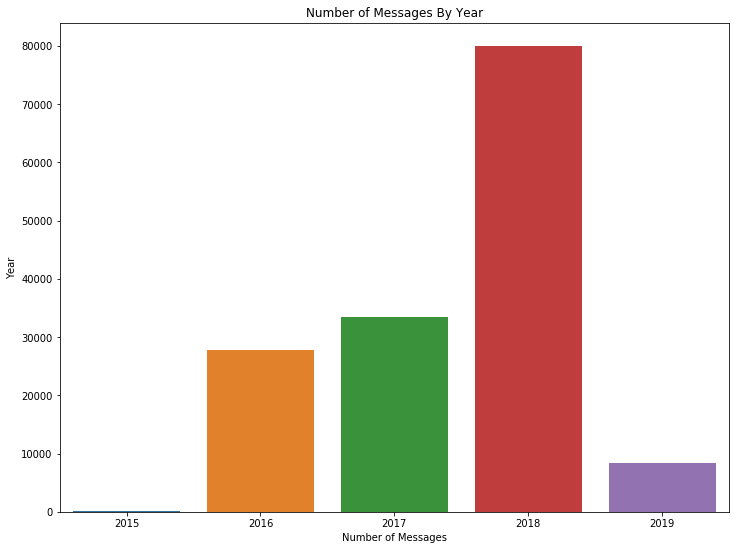

In [32]:
ax = sns.countplot(data['date'].dt.year)
ax.set_ylabel("Year")
ax.set_xlabel("Number of Messages")
ax.set_title("Number of Messages By Year");

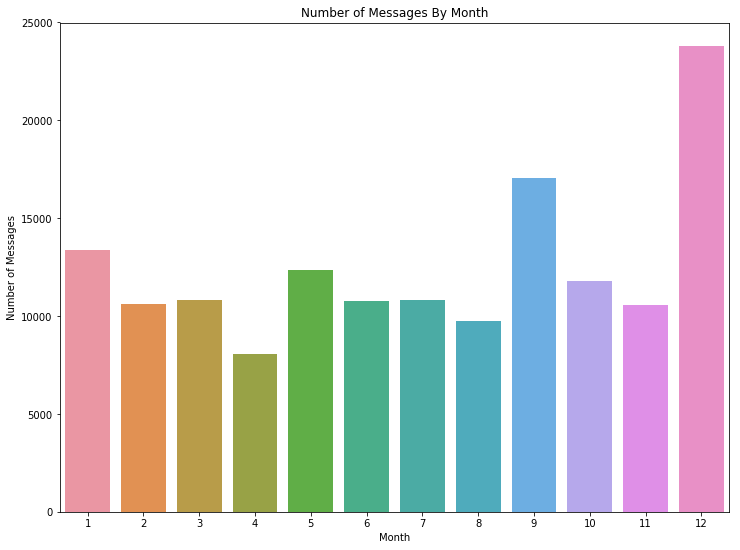

In [33]:
ax = sns.countplot(data['date'].dt.month)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Messages")
ax.set_title("Number of Messages By Month");

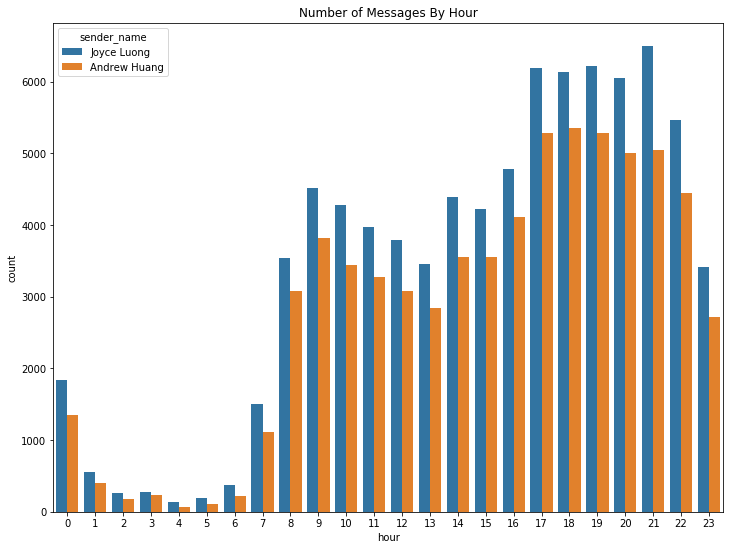

In [34]:
data['hour'] = data['date'].dt.hour
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = sns.countplot(x='hour',hue='sender_name',data=data)
ax.set_title("Number of Messages By Hour");

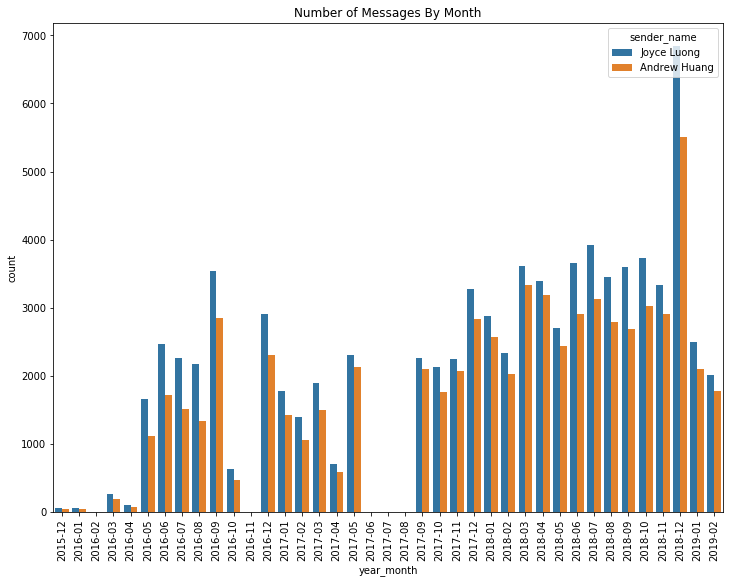

In [102]:
year_month = sorted(list(data['year_month'].unique()) + ['2016-02', '2016-11', '2017-06', '2017-07', '2017-08']) # order to display the x-axis
ax = sns.countplot(x='year_month', hue='sender_name', data=data, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Number of Messages By Month");

In [103]:
count_chars = lambda row: sum([len(str(i)) for i in row])
reduced = data.loc[:, ['year_month', 'sender_name', 'content']]

char_len = reduced.groupby([reduced['year_month'], reduced['sender_name']]).agg(count_chars)
char_len.reset_index(inplace=True)

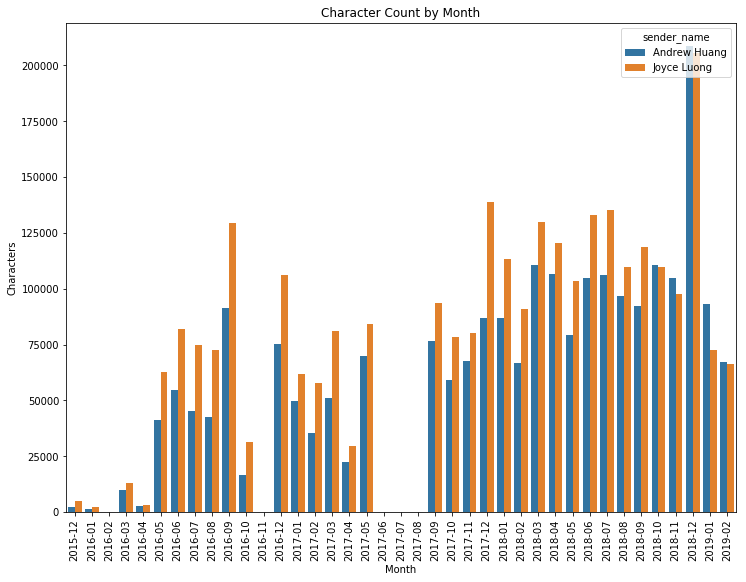

In [114]:
ax = sns.barplot(x='year_month', y='content', hue='sender_name', data=char_len, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Character Count by Month");
ax.set_ylabel("Characters")
ax.set_xlabel("Month");

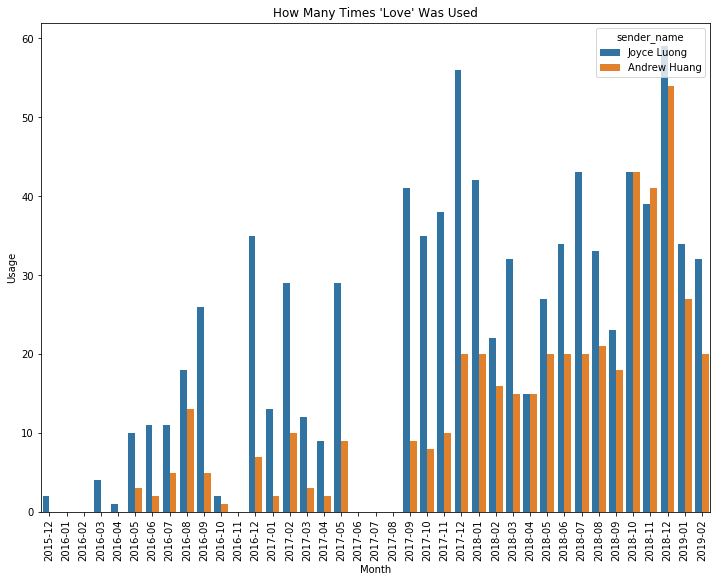

In [115]:
love = data[data['content'].str.contains('love', na=False)]
love = love.loc[:, ['content']]

count = lambda row: sum([len(str(i)) for i in row])
love = love.groupby([reduced['year_month'], reduced['sender_name']]).count()
love.reset_index(inplace=True)

ax = sns.barplot(x='year_month', y='content', hue='sender_name', data=love, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("How Many Times 'Love' Was Used");
ax.set_ylabel("Usage")
ax.set_xlabel("Month");

In [106]:
data['reaction1'].value_counts()

👍    5101
😍    2104
😮    1449
😆     992
😢     868
👎     343
😠     146
🐙       1
🐰       1
💪       1
🐸       1
🐯       1
Name: reaction1, dtype: int64

In [107]:
data['actor1'].value_counts()

Joyce Luong     7891
Andrew Huang    3117
Name: actor1, dtype: int64

In [119]:
count_reactions = lambda row: sum([len(str(i)) for i in row])
reactions_temp = data.loc[:, ['year_month','reaction1', 'actor1']].dropna(subset=['reaction1'])

reactions = reactions_temp.groupby([reactions_temp['year_month'], reactions_temp['actor1']]).agg(count_reactions)
reactions.reset_index(inplace=True)
reactions.head()

,year_month,actor1,reaction1
0,2017-04,Andrew Huang,5
1,2017-04,Joyce Luong,8
2,2017-05,Andrew Huang,30
3,2017-05,Joyce Luong,56
4,2017-09,Andrew Huang,73


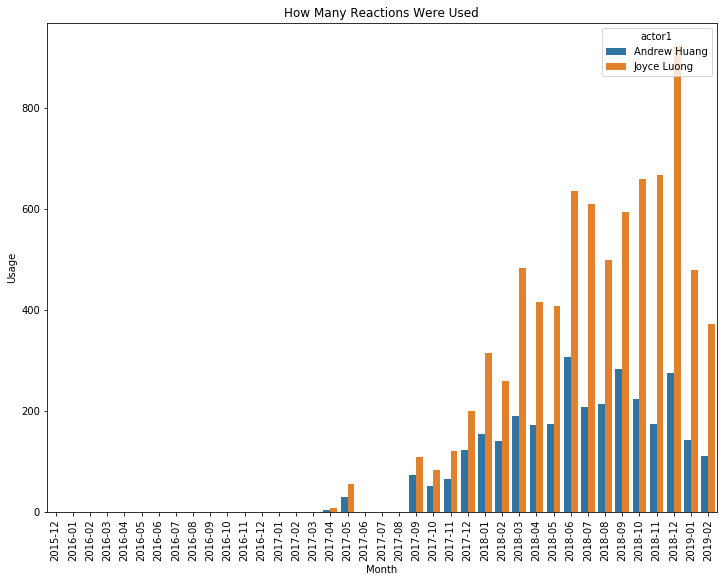

In [121]:
year_month = sorted(list(data['year_month'].unique()) + ['2016-02', '2016-11', '2017-06', '2017-07', '2017-08']) # order to display the x-axis

ax = sns.barplot(x='year_month', y='reaction1', hue='actor1', data=reactions, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("How Many Reactions Were Used");
ax.set_ylabel("Usage")
ax.set_xlabel("Month");

In [110]:
count_reactions = lambda row: list(row)
reactions_temp = data.loc[:, ['reaction1', 'actor1', 'content']].dropna(subset=['reaction1'])

reactions = reactions_temp.groupby([reactions_temp['reaction1'], reactions_temp['actor1']]).count()
reactions.reset_index(inplace=True)

reactions.head(10)

,reaction1,actor1,content
0,🐙,Andrew Huang,1
1,🐯,Andrew Huang,1
2,🐰,Andrew Huang,1
3,🐸,Andrew Huang,1
4,👍,Andrew Huang,1521
5,👍,Joyce Luong,3580
6,👎,Andrew Huang,76
7,👎,Joyce Luong,266
8,💪,Andrew Huang,1
9,😆,Andrew Huang,233


In [111]:
reactions[reactions['content'] > 1].head()

,reaction1,actor1,content
4,👍,Andrew Huang,1521
5,👍,Joyce Luong,3580
6,👎,Andrew Huang,76
7,👎,Joyce Luong,266
9,😆,Andrew Huang,233


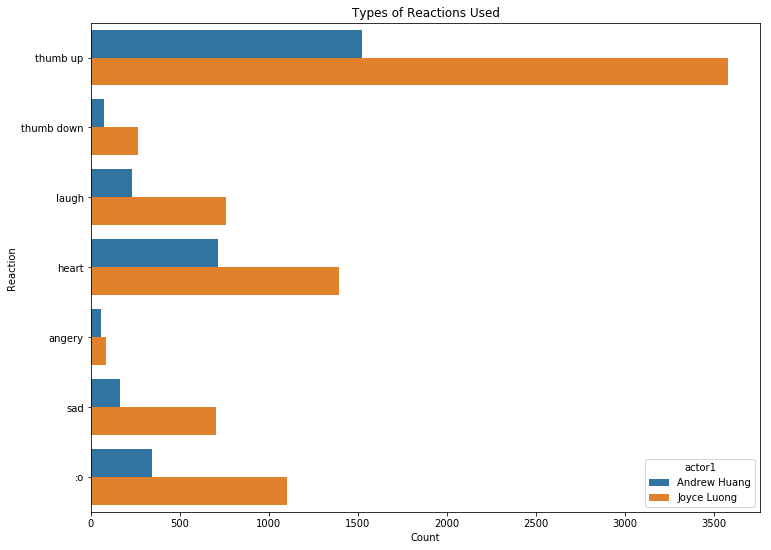

In [112]:
ax = sns.barplot(x='content', y='reaction1', hue='actor1', data=reactions[reactions['content'] > 1])
ax.set_title("Types of Reactions Used");
ax.set_ylabel("Reaction")
ax.set_xlabel("Count");
ax.set_yticklabels(('thumb up', 'thumb down', 'laugh', 'heart', 'angery', 'sad', ':o'));

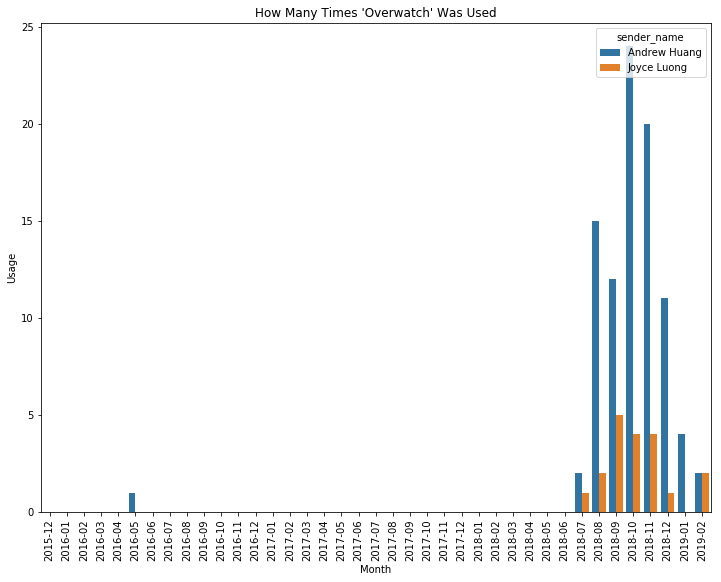

In [136]:
overwatch = data[data['content'].str.contains('overwatch', na=False)]
overwatch = overwatch.loc[:, ['content']]

count = lambda row: list(row)
overwatch = overwatch.groupby([reduced['year_month'], reduced['sender_name']]).count()
overwatch.reset_index(inplace=True)

ax = sns.barplot(x='year_month', y='content', hue='sender_name', data=overwatch, order=year_month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("How Many Times 'Overwatch' Was Used");
ax.set_ylabel("Usage")
ax.set_xlabel("Month");

In [135]:
overwatch = data[data['content'].str.contains('overwatch', na=False)]
overwatch = overwatch.loc[:, ['content']]

count = lambda row: list(row)
overwatch = overwatch.groupby([reduced['year_month'], reduced['sender_name']]).agg(count)
overwatch

content
year_month sender_name                                                    
2016-05    Andrew Huang                     [Want to play overwatch maybe]
2018-07    Andrew Huang  [We're gonna need gaming rigs for overwatch, w...
           Joyce Luong                                    [overwatch vids]
2018-08    Andrew Huang  [sure, so I'll commit to not playing overwatch...
           Joyce Luong   [Between `{book pact/mid aug trip/clim/overwat...
2018-09    Andrew Huang  [I want to play more overwatch now lol, instea...
           Joyce Luong   [Playing overwatch?, And when I’m over, and we...
2018-10    Andrew Huang  [do you like talking  about overwatch with me?...
           Joyce Luong   [I'm not getting linked to an overwatch stream...
2018-11    Andrew Huang  [i think overwatch with two of us in the same ...
           Joyce Luong   [well, better than playing a ton of overwatch ...
2018-12    Andrew Huang  [lke overwatch, You wanna see the sickest pro ...
           Joyce Luong        [https://charsiewspace.com/tagged/overwatch]
2019-01    Andrew Huang  [I was watching an overwatch video and the per...
2019-02    Andrew Huang  [Lots of overwatch, https://kotaku.com/overwat...
           Joyce Luong   [I've also noticed that you seem to be pretty ...

In [113]:
# To save everything to .json
# data.to_json('output/feb-17-2019.json')